In [2]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

In [3]:
img_dir = 'images'
collies = 'collies.JPG'
dogs = 'multiple_dogs.jpg'
snake = 'snake.JPEG'
bird = 'water-bird.JPEG'

collies_path = os.path.join(img_dir, collies)
dogs_path = os.path.join(img_dir, dogs)
snake_path = os.path.join(img_dir, snake)
bird_path = os.path.join(img_dir, bird)

collies_img = PIL.Image.open(collies_path)
dogs_img = PIL.Image.open(dogs_path)
snake_img = PIL.Image.open(snake_path)
bird_img = PIL.Image.open(bird_path)

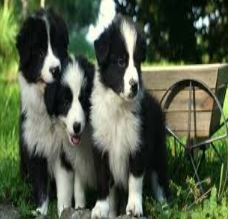

In [4]:
collies_img

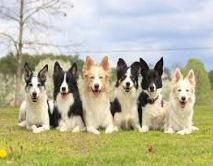

In [5]:
dogs_img

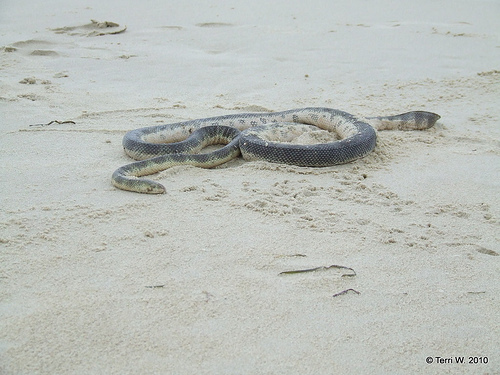

In [6]:
snake_img

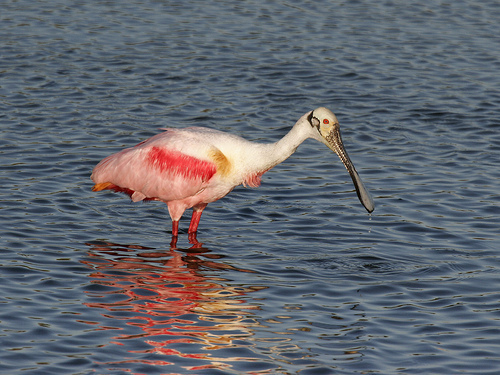

In [7]:
bird_img

In [8]:
tensors = {}

normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for image, name in zip((collies_img, dogs_img, snake_img, bird_img), ('collies', 'dogs', 'snake', 'bird')):
    
    torch_img = torch.from_numpy(np.asarray(image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_torch_img = normalizer(torch_img)
    
    tensors.update({
        name: [
            torch_img,
            normed_torch_img
        ]
    })

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  import sys
c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\torch\nn\functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [9]:
vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda();

In [10]:
cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


In [11]:
masks = dict()
for (gradcam, gradcam_pp), key in zip(cam_dict.values(), cam_dict.keys()):
    
    for name, list_of_tensors in tensors.items():
        mask, _ = gradcam(list_of_tensors[1])

        mask_pp, _ = gradcam_pp(list_of_tensors[1])
    
        masks.update({
            name: [
                mask, mask_pp
            ]
        })

## Preparing masks to vgg input

In [21]:
input_masks = dict()

for key, tensors in masks.items():
    
    mask = cv2.cvtColor(np.uint8(255 * tensors[0].cpu().squeeze()), cv2.COLOR_GRAY2RGB)
    torch_img = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    
    mask_pp = cv2.cvtColor(np.uint8(255 * tensors[1].cpu().squeeze()), cv2.COLOR_GRAY2RGB)
    torch_img_pp = torch.tensor(mask_pp).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img_pp = F.upsample(torch_img_pp, size=(224, 224), mode='bilinear', align_corners=False)
    
    input_masks[key] = [
        torch_img,
        torch_img_pp
    ]

In [44]:
F.softmax(pred).shape

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


torch.Size([1, 1000])

In [47]:
predictions = dict()

for key, tensors in input_masks.items():
    
    mask_pred = F.softmax(vgg(tensors[0]))
    mask_pp_pred = F.softmax(vgg(tensors[1]))
    
    predictions[key] = [
        mask_pred[0, mask_pred.argmax(1)],
        mask_pp_pred[0, mask_pp_pred.argmax(1)]
    ]

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [48]:
predictions

{'collies': [tensor([0.1572], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.1997], device='cuda:0', grad_fn=<IndexBackward>)],
 'dogs': [tensor([0.0531], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0507], device='cuda:0', grad_fn=<IndexBackward>)],
 'snake': [tensor([0.1141], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0652], device='cuda:0', grad_fn=<IndexBackward>)],
 'bird': [tensor([0.0246], device='cuda:0', grad_fn=<IndexBackward>),
  tensor([0.0354], device='cuda:0', grad_fn=<IndexBackward>)]}

In [56]:
# normal prediction

tensors = {}

normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for image, name in zip((collies_img, dogs_img, snake_img, bird_img), ('collies', 'dogs', 'snake', 'bird')):
    
    torch_img = torch.from_numpy(np.asarray(image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
    torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_torch_img = normalizer(torch_img)
    
    tensors.update({
        name: [
            normed_torch_img
        ]
    })

normal_predictions = dict()

for key, tensor in tensors.items():
    
    pred = F.softmax(vgg(tensor[0]))
    
    normal_predictions[key] = pred[0, pred.argmax(1)]

c:\users\mathe\projects\gradcam_plus_plus-pytorch\env\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [57]:
normal_predictions

{'collies': tensor([0.8405], device='cuda:0', grad_fn=<IndexBackward>),
 'dogs': tensor([0.3855], device='cuda:0', grad_fn=<IndexBackward>),
 'snake': tensor([0.5433], device='cuda:0', grad_fn=<IndexBackward>),
 'bird': tensor([1.0000], device='cuda:0', grad_fn=<IndexBackward>)}

## Metrics

### Average drop

In [71]:
r = 0
r_pp = 0

for k in ('collies', 'dogs', 'snake', 'bird'):
    
    y = normal_predictions[k].cpu().data.numpy()[0]
    o = predictions[k][0].cpu().data.numpy()[0]
    o_pp = predictions[k][1].cpu().data.numpy()[0]
    
    r += _max(y - o) / y
    r_pp += _max(y - o_pp) / y

In [79]:
print("Average drop for Grad-CAM: {}".format(r))
print("Average drop for Grad-CAM++: {}".format(r_pp))

Average drop for Grad-CAM: 3.440488636493683
Average drop for Grad-CAM++: 3.475645661354065


### Increase in confidence

In [80]:
diff = dict()

for k in ('collies', 'dogs', 'snake', 'bird'):
    
    y = normal_predictions[k].cpu().data.numpy()[0]
    o = predictions[k][0].cpu().data.numpy()[0]
    o_pp = predictions[k][1].cpu().data.numpy()[0]
    
    r = y - o
    r_pp = y - o_pp
    
    diff[k] = (
        1 if r < 0 else 0,
        1 if r_pp < 0 else 0
    )

In [81]:
diff

{'collies': (0, 0), 'dogs': (0, 0), 'snake': (0, 0), 'bird': (0, 0)}

In [82]:
# all zero :/